In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

# 1.NLP Preprocessing


## 1-1. 데이터 불러오기

In [4]:
PATH = '/content/drive/MyDrive/news/'

In [14]:
train = pd.read_csv(PATH + "train_data.csv")
test = pd.read_csv(PATH + "test_data.csv")
submission = pd.read_csv(PATH + "sample_submission.csv")

In [15]:
train

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


## 1-3. 데이터 시각화

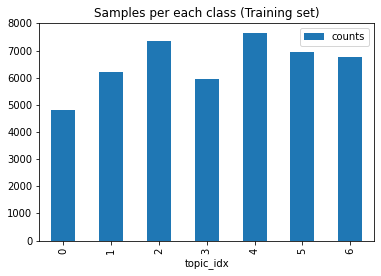

In [16]:
# 작가별 분포도 확인 
train.groupby(train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

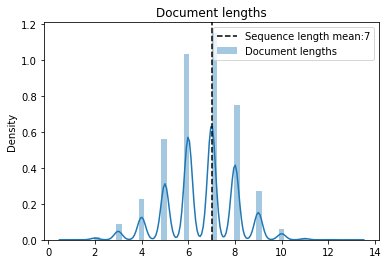

 가장 긴 문장은 13 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있습니다.


In [17]:
# 문장 길이 분포도 확인
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

위 그래프에서 확인했듯 평균 길이는 20 인 것을 알 수 있다.
차후 sequence에 적용할 max length는 150 정도로 적당히 잡아준다

# 2.Vectorization

## 2.1 Tokenization

In [18]:
# 먼저 train 데이터와 test 데이터 인덱스 없이 배열로 만들기
X_train = np.array([x for x in train['title']])
X_test = np.array([x for x in test['title']])
Y_train = np.array([x for x in train['topic_idx']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(45654,)
(9131,)
(45654,)


In [19]:
print(X_train)
print(X_test)
print(Y_train)

['인천→핀란드 항공기 결항…휴가철 여행객 분통' '실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화'
 '이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것' ... '게시판 키움증권 2020 키움 영웅전 실전투자대회'
 '답변하는 배기동 국립중앙박물관장' '2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후']
['유튜브 내달 2일까지 크리에이터 지원 공간 운영' '어버이날 맑다가 흐려져…남부지방 옅은 황사'
 '내년부터 국가RD 평가 때 논문건수는 반영 않는다' ... '40년 전 부마항쟁 부산 시위 사진 2점 최초 공개'
 '게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계' '유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구']
[4 4 4 ... 1 2 2]


In [20]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

45654 9131


# 3.Embediing

In [21]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [22]:
# 독립변수 데이터 전처리
  ## 문장의 길이기 제각각이기 때문에 벡터 크기 다 다름
  ## 그러므로 최대 시퀀스 길이 크기(211) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(45654, 14) (9131, 14)


In [23]:
# 종속변수 데이터 전처리
train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩
print(train_y)
print(train_y.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(45654, 7)


# 4.Modeling 

## 4.1 simple RNN

In [24]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

In [25]:
# Simple RNN 레이어를 사용한 모델 (model1) 정의
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model1.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 200)           400000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 14, 64)            16960     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 14, 64)            8256      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 7)                 455       
Total params: 433,927
Trainable params: 433,927
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 모델 실행해보기
history = model1.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
366/366 [==============================] - 17s 39ms/step - loss: 1.0058 - accuracy: 0.6494 - val_loss: 1.3672 - val_accuracy: 0.4691
Epoch 2/10
366/366 [==============================] - 14s 39ms/step - loss: 0.7464 - accuracy: 0.7417 - val_loss: 1.2445 - val_accuracy: 0.5481
Epoch 3/10
366/366 [==============================] - 14s 39ms/step - loss: 0.6735 - accuracy: 0.7595 - val_loss: 1.1472 - val_accuracy: 0.5786
Epoch 4/10
366/366 [==============================] - 14s 38ms/step - loss: 0.6208 - accuracy: 0.7761 - val_loss: 1.2677 - val_accuracy: 0.5557
Epoch 5/10
366/366 [==============================] - 14s 38ms/step - loss: 0.5791 - accuracy: 0.7894 - val_loss: 1.2829 - val_accuracy: 0.5642
Epoch 6/10
366/366 [==============================] - 14s 39ms/step - loss: 0.5394 - accuracy: 0.8018 - val_loss: 1.2951 - val_accuracy: 0.5677
Epoch 7/10
366/366 [==============================] - 14s 38ms/step - loss: 0.5110 - accuracy: 0.8091 - val_loss: 1.3977 - val_accuracy:

<function matplotlib.pyplot.show>

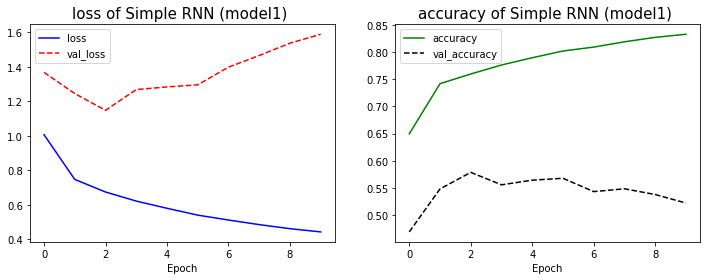

In [27]:
# Simple RNN 모델 (model1) 학습 결과 확인
plt.figure(figsize=(12, 4))
plt.title('Simple RNN (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

Simple RNN는 Epoch 한번 당 시간도 오래 걸리고, 학습이 되지 않는 것을 확인할 수 있다.

## 4.2 단방향 LSTM

In [29]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

In [31]:
# LSTM 레이어를 사용한 모델 (model2) 정의
model2 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model2.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 200)           400000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 64)            67840     
_________________________________________________________________
lstm_4 (LSTM)                (None, 14, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 534,343
Trainable params: 534,343
Non-trainable params: 0
_________________________________________________________________


In [32]:
# 모델 실행해보기
history = model2.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
366/366 [==============================] - 10s 13ms/step - loss: 1.0782 - accuracy: 0.6051 - val_loss: 1.2989 - val_accuracy: 0.5237
Epoch 2/10
366/366 [==============================] - 4s 10ms/step - loss: 0.7873 - accuracy: 0.7313 - val_loss: 1.1444 - val_accuracy: 0.5887
Epoch 3/10
366/366 [==============================] - 4s 10ms/step - loss: 0.7417 - accuracy: 0.7457 - val_loss: 1.1602 - val_accuracy: 0.5570
Epoch 4/10
366/366 [==============================] - 4s 10ms/step - loss: 0.7187 - accuracy: 0.7523 - val_loss: 1.1912 - val_accuracy: 0.5450
Epoch 5/10
366/366 [==============================] - 4s 10ms/step - loss: 0.6980 - accuracy: 0.7574 - val_loss: 1.1227 - val_accuracy: 0.5816
Epoch 6/10
366/366 [==============================] - 4s 10ms/step - loss: 0.6852 - accuracy: 0.7605 - val_loss: 1.1441 - val_accuracy: 0.5727
Epoch 7/10
366/366 [==============================] - 4s 10ms/step - loss: 0.6681 - accuracy: 0.7643 - val_loss: 1.1494 - val_accuracy: 0.564

<function matplotlib.pyplot.show>

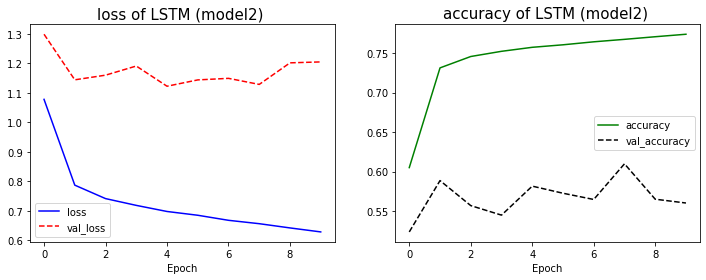

In [33]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

학습 시간은 단축되었지만, 단방향 LSTM 으로도 학습이 되지 않는 것을 확인할 수 있다.

## 4.3 양방향 LSTM

In [34]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'
#oov_tok = "<OOV>"

In [36]:
# 양방향 LSTM 레이어를 사용한 모델 (model3) 정의
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model3.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 14, 200)           400000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 14, 128)           135680    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 14, 128)           98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 903       
Total params: 734,215
Trainable params: 734,215
Non-trainable params: 0
_________________________________________________________________


In [37]:
# 모델 실행해보기
history = model3.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2) 
  # 양방향 LSTM 레이어에서는 batch size 를 100으로 잡고 50회 학습 해보았다.

Epoch 1/50
366/366 [==============================] - 14s 20ms/step - loss: 1.0494 - accuracy: 0.6195 - val_loss: 1.2036 - val_accuracy: 0.5615
Epoch 2/50
366/366 [==============================] - 6s 15ms/step - loss: 0.7740 - accuracy: 0.7342 - val_loss: 1.1613 - val_accuracy: 0.5668
Epoch 3/50
366/366 [==============================] - 6s 15ms/step - loss: 0.7321 - accuracy: 0.7464 - val_loss: 1.0848 - val_accuracy: 0.5981
Epoch 4/50
366/366 [==============================] - 6s 15ms/step - loss: 0.7006 - accuracy: 0.7546 - val_loss: 1.1740 - val_accuracy: 0.5423
Epoch 5/50
366/366 [==============================] - 6s 15ms/step - loss: 0.6778 - accuracy: 0.7589 - val_loss: 1.1496 - val_accuracy: 0.5704
Epoch 6/50
366/366 [==============================] - 6s 15ms/step - loss: 0.6616 - accuracy: 0.7628 - val_loss: 1.1296 - val_accuracy: 0.5837
Epoch 7/50
366/366 [==============================] - 6s 15ms/step - loss: 0.6456 - accuracy: 0.7672 - val_loss: 1.1096 - val_accuracy: 0.594

<function matplotlib.pyplot.show>

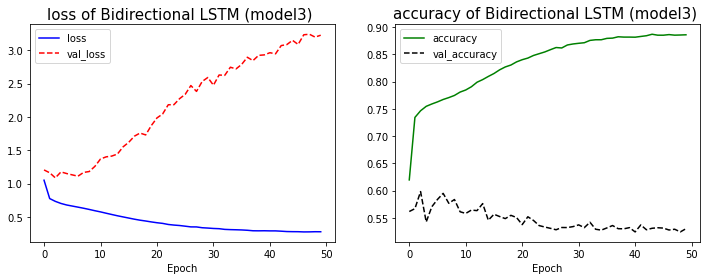

In [39]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

loss 값은 줄어드는 것을 볼 수 있으나, val_loss 값은 점점 상승한다
accuracy 도 마찬가지로 val_accuracy 는 제대로 결과가 나오지 않는다.

모델 성능 평가의 일반화를 위해 교차 검증을 해야할 것 같다.

## 4.4 교차 검증 적용

- 계층 교차검증(StratifiedKFold) 적용하고 모델 일반화

In [40]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512)

training model for CV #1
Epoch 1/10
72/72 [==============================] - 2s 22ms/step - loss: 0.6590 - accuracy: 0.8191 - val_loss: 0.5847 - val_accuracy: 0.8224
Epoch 2/10
72/72 [==============================] - 2s 21ms/step - loss: 0.4742 - accuracy: 0.8414 - val_loss: 0.5622 - val_accuracy: 0.8237
Epoch 3/10
72/72 [==============================] - 2s 21ms/step - loss: 0.4219 - accuracy: 0.8528 - val_loss: 0.5571 - val_accuracy: 0.8228
Epoch 4/10
72/72 [==============================] - 2s 21ms/step - loss: 0.3940 - accuracy: 0.8587 - val_loss: 0.5660 - val_accuracy: 0.8200
Epoch 5/10
72/72 [==============================] - 2s 21ms/step - loss: 0.3755 - accuracy: 0.8630 - val_loss: 0.5737 - val_accuracy: 0.8172
Epoch 6/10
72/72 [==============================] - 2s 21ms/step - loss: 0.3605 - accuracy: 0.8658 - val_loss: 0.5817 - val_accuracy: 0.8154
Epoch 7/10
72/72 [==============================] - 2s 21ms/step - loss: 0.3487 - accuracy: 0.8683 - val_loss: 0.5951 - val_accur

기존 보다 개선된 결과 값을 보여준다.
하지만 val_loss 와 val_accuracy 결과값을 보면 조기종료 옵션을 추가해야할 것 같다.

In [42]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 7))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model3.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
72/72 [==============================] - 2s 22ms/step - loss: 0.2896 - accuracy: 0.8785 - val_loss: 0.2975 - val_accuracy: 0.8770
Epoch 2/10
72/72 [==============================] - 2s 21ms/step - loss: 0.2849 - accuracy: 0.8798 - val_loss: 0.3099 - val_accuracy: 0.8715
Epoch 3/10
72/72 [==============================] - 2s 21ms/step - loss: 0.2823 - accuracy: 0.8807 - val_loss: 0.3234 - val_accuracy: 0.8689
Epoch 4/10
72/72 [==============================] - 1s 21ms/step - loss: 0.2795 - accuracy: 0.8811 - val_loss: 0.3374 - val_accuracy: 0.8669
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
training model for CV #2
Epoch 1/10
72/72 [==============================] - 2s 21ms/step - loss: 0.2914 - accuracy: 0.8770 - val_loss: 0.2853 - val_accuracy: 0.8807
Epoch 2/10
72/72 [==============================] - 2s 21ms/step - loss: 0.2862 - accuracy: 0.8792 - val_loss: 0.3011 - val_accuracy: 0.8735
Epoch 3/10
72/72 [==

## 4.5 테스트 데이터 적용

In [43]:
# 테스트 데이터의 예측값 확인
test_y

array([[9.19452175e-01, 3.70534908e-05, 8.00730935e-02, ...,
        4.84523187e-06, 8.96312072e-05, 2.85860388e-04],
       [8.25175913e-02, 1.06858810e-01, 2.32146721e-01, ...,
        1.09151062e-01, 6.97348276e-02, 1.26029879e-01],
       [3.64934131e-01, 6.30707584e-01, 4.25912091e-03, ...,
        6.50975339e-05, 8.26598159e-08, 2.53357219e-05],
       ...,
       [2.73476664e-09, 2.91278629e-05, 1.19794656e-01, ...,
        5.49258624e-04, 3.98732575e-06, 2.10561517e-03],
       [1.53710339e-01, 1.31447507e-04, 1.05901030e-01, ...,
        6.29704510e-03, 1.92916762e-05, 4.95813001e-03],
       [2.00573417e-05, 4.14072454e-03, 9.88123000e-01, ...,
        5.12174537e-04, 6.50821325e-07, 7.20292729e-03]])

In [44]:
topic = []
for i in range(len(test_y)):
    topic.append(np.argmax(test_y[i]))

In [46]:
submission

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0
...,...,...
9126,54780,0
9127,54781,0
9128,54782,0
9129,54783,0


In [48]:
# sample_submission 에 대입
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,0
1,45655,3
2,45656,1
3,45657,2
4,45658,3
...,...,...
9126,54780,2
9127,54781,3
9128,54782,3
9129,54783,3


In [49]:
submission.to_csv(PATH + 'LSTM.csv',index = False)

# E.O.D